## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp018'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

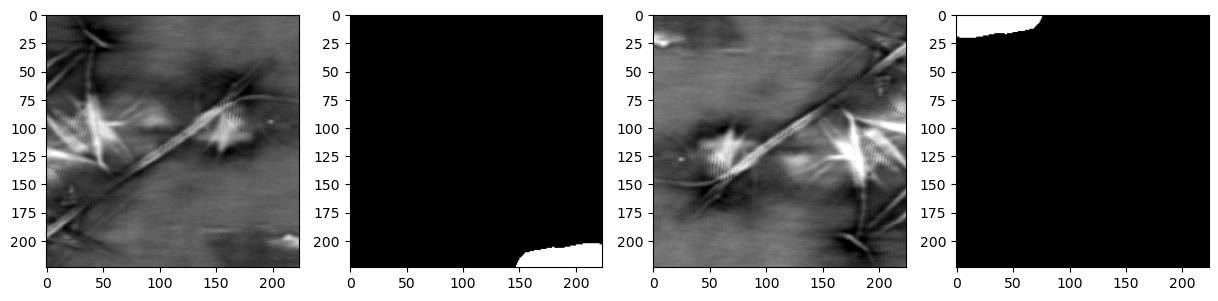

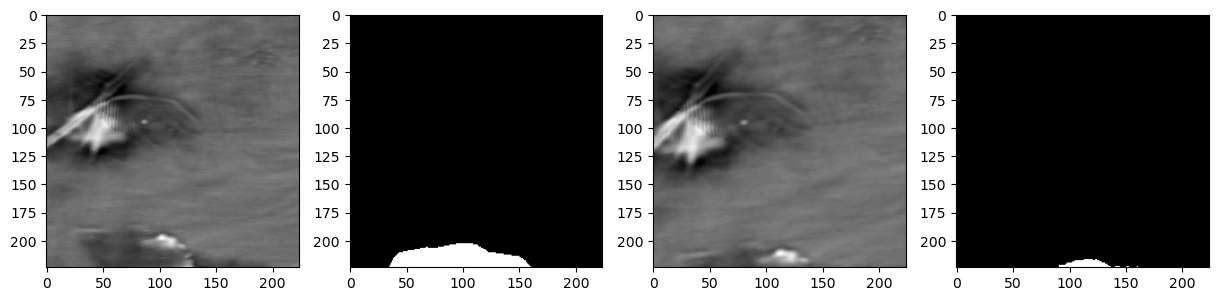

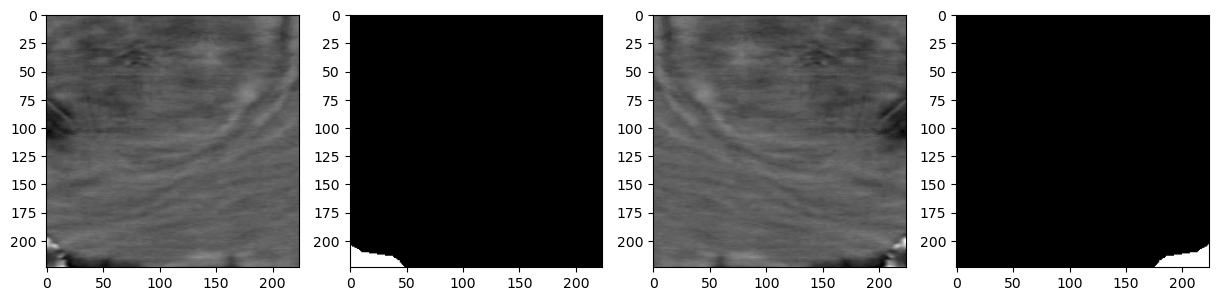

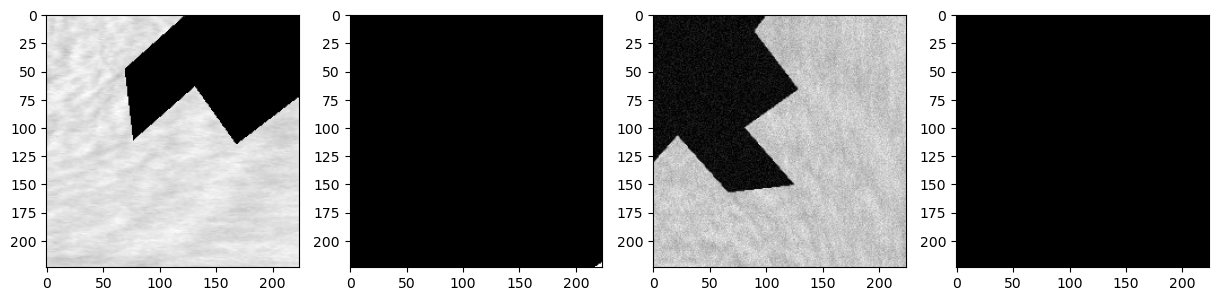

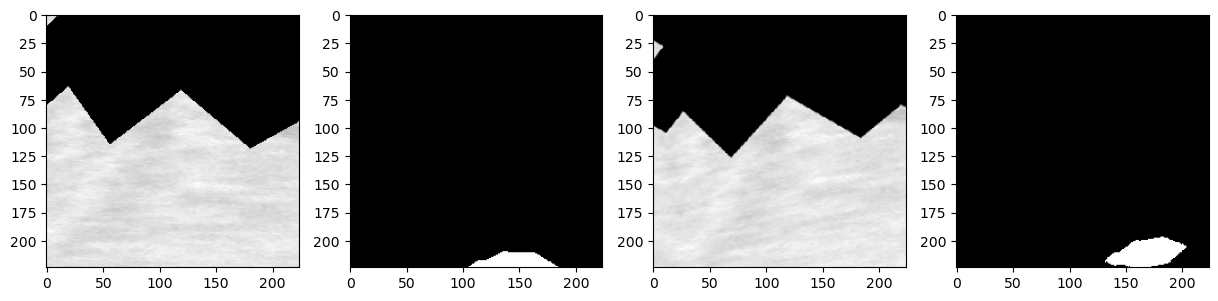

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48135

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14291983576221592
th: 0.15, fbeta: 0.22877146508205856
th: 0.2, fbeta: 0.2570094884887447
th: 0.25, fbeta: 0.2845980408128875
th: 0.3, fbeta: 0.316241204742654
th: 0.35, fbeta: 0.3510099308057662
th: 0.4, fbeta: 0.38426281194292466
th: 0.45, fbeta: 0.4057022417238555


best_th: 0.45, fbeta: 0.4057022417238555
Epoch 1 - avg_train_loss: 0.4117  avg_val_loss: 0.3204  time: 226s
Epoch 1 - avgScore: 0.4057
Epoch 1 - Save Best Score: 0.4057 Model
Epoch 1 - Save Best Loss: 0.3204 Model


th: 0.5, fbeta: 0.39656788172613


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23549092949975617
th: 0.15, fbeta: 0.2769435031020681
th: 0.2, fbeta: 0.3145077963634087
th: 0.25, fbeta: 0.3504895708197459
th: 0.3, fbeta: 0.3835689930842641
th: 0.35, fbeta: 0.4117118905783259
th: 0.4, fbeta: 0.4315790084550323
th: 0.45, fbeta: 0.44350915631836674


best_th: 0.45, fbeta: 0.44350915631836674
Epoch 2 - avg_train_loss: 0.3202  avg_val_loss: 0.2816  time: 229s
Epoch 2 - avgScore: 0.4435
Epoch 2 - Save Best Score: 0.4435 Model
Epoch 2 - Save Best Loss: 0.2816 Model


th: 0.5, fbeta: 0.4409353994604097


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.3830449081084479
th: 0.15, fbeta: 0.4371676824930365
th: 0.2, fbeta: 0.4678333960797562
th: 0.25, fbeta: 0.4865838394938887
th: 0.3, fbeta: 0.4979108685889448
th: 0.35, fbeta: 0.502806868590683
th: 0.4, fbeta: 0.5032949876685063
th: 0.45, fbeta: 0.498480600084805


best_th: 0.4, fbeta: 0.5032949876685063
Epoch 3 - avg_train_loss: 0.2744  avg_val_loss: 0.2390  time: 228s
Epoch 3 - avgScore: 0.5033
Epoch 3 - Save Best Score: 0.5033 Model
Epoch 3 - Save Best Loss: 0.2390 Model


th: 0.5, fbeta: 0.4868873048002632


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35547903011441134
th: 0.15, fbeta: 0.39161606084947953
th: 0.2, fbeta: 0.4188409820124224
th: 0.25, fbeta: 0.4398223271235117
th: 0.3, fbeta: 0.45587271178447697
th: 0.35, fbeta: 0.4733959717898485
th: 0.4, fbeta: 0.48902142304978263
th: 0.45, fbeta: 0.49927334931656686


best_th: 0.5, fbeta: 0.5052282041419057
Epoch 4 - avg_train_loss: 0.2445  avg_val_loss: 0.2371  time: 228s
Epoch 4 - avgScore: 0.5052
Epoch 4 - Save Best Score: 0.5052 Model
Epoch 4 - Save Best Loss: 0.2371 Model


th: 0.5, fbeta: 0.5052282041419057


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3322861902961081
th: 0.15, fbeta: 0.36823355484597625
th: 0.2, fbeta: 0.39881272026806625
th: 0.25, fbeta: 0.42078785479722636
th: 0.3, fbeta: 0.4414689253712553
th: 0.35, fbeta: 0.4591617065949866
th: 0.4, fbeta: 0.47031410957054287
th: 0.45, fbeta: 0.48030755506342865


best_th: 0.5, fbeta: 0.48826896162603994
Epoch 5 - avg_train_loss: 0.2297  avg_val_loss: 0.2396  time: 229s
Epoch 5 - avgScore: 0.4883


th: 0.5, fbeta: 0.48826896162603994


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32849076030666513
th: 0.15, fbeta: 0.36765201227449684
th: 0.2, fbeta: 0.40019356257845495
th: 0.25, fbeta: 0.4276162550575094
th: 0.3, fbeta: 0.4498740065032986
th: 0.35, fbeta: 0.4717475176689831
th: 0.4, fbeta: 0.48643616644690285
th: 0.45, fbeta: 0.4969975623658797


best_th: 0.5, fbeta: 0.5030503508208918
Epoch 6 - avg_train_loss: 0.2158  avg_val_loss: 0.2340  time: 227s
Epoch 6 - avgScore: 0.5031


th: 0.5, fbeta: 0.5030503508208918


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46707121860097256
th: 0.15, fbeta: 0.4989874514243567
th: 0.2, fbeta: 0.5201482950741099
th: 0.25, fbeta: 0.5402919442294722
th: 0.3, fbeta: 0.5522257711037283
th: 0.35, fbeta: 0.5567855715184753
th: 0.4, fbeta: 0.5538893503773845
th: 0.45, fbeta: 0.5437607038922521


best_th: 0.35, fbeta: 0.5567855715184753
Epoch 7 - avg_train_loss: 0.2030  avg_val_loss: 0.2641  time: 228s
Epoch 7 - avgScore: 0.5568
Epoch 7 - Save Best Score: 0.5568 Model
Epoch 7 - Save Best Loss: 0.2641 Model


th: 0.5, fbeta: 0.5317441400593961


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3645515112497864
th: 0.15, fbeta: 0.4007610725241284
th: 0.2, fbeta: 0.4281588397671185
th: 0.25, fbeta: 0.44742906773998253
th: 0.3, fbeta: 0.4610121303326466
th: 0.35, fbeta: 0.4741647631604055
th: 0.4, fbeta: 0.48007902525625
th: 0.45, fbeta: 0.48041091000257014


best_th: 0.45, fbeta: 0.48041091000257014
Epoch 8 - avg_train_loss: 0.1896  avg_val_loss: 0.2525  time: 229s
Epoch 8 - avgScore: 0.4804


th: 0.5, fbeta: 0.4727996105936608


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4948149350559835
th: 0.15, fbeta: 0.5186563062882789
th: 0.2, fbeta: 0.5351346198472281
th: 0.25, fbeta: 0.542694139273724
th: 0.3, fbeta: 0.5411806114401093
th: 0.35, fbeta: 0.5324717595053569
th: 0.4, fbeta: 0.5145334643360986
th: 0.45, fbeta: 0.489025537807078


best_th: 0.25, fbeta: 0.542694139273724
Epoch 9 - avg_train_loss: 0.1769  avg_val_loss: 0.2934  time: 229s
Epoch 9 - avgScore: 0.5427


th: 0.5, fbeta: 0.453323733579997


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38589902884078325
th: 0.15, fbeta: 0.40295460325378085
th: 0.2, fbeta: 0.41609312451971964
th: 0.25, fbeta: 0.42713298671169125
th: 0.3, fbeta: 0.4374119342380332
th: 0.35, fbeta: 0.4457081249802246
th: 0.4, fbeta: 0.453858522259583
th: 0.45, fbeta: 0.4631153957134313


best_th: 0.5, fbeta: 0.4678688368728303
Epoch 10 - avg_train_loss: 0.1657  avg_val_loss: 0.2855  time: 228s
Epoch 10 - avgScore: 0.4679


th: 0.5, fbeta: 0.4678688368728303


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38555955239843503
th: 0.15, fbeta: 0.41228102168225045
th: 0.2, fbeta: 0.43560166556872154
th: 0.25, fbeta: 0.4541648402783127
th: 0.3, fbeta: 0.4700769861844961
th: 0.35, fbeta: 0.48684966041916317
th: 0.4, fbeta: 0.5023959175514318
th: 0.45, fbeta: 0.5143449619562471


best_th: 0.5, fbeta: 0.5221157376909645
Epoch 11 - avg_train_loss: 0.1553  avg_val_loss: 0.2666  time: 229s
Epoch 11 - avgScore: 0.5221


th: 0.5, fbeta: 0.5221157376909645


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40768037358788634
th: 0.15, fbeta: 0.4366322525461375
th: 0.2, fbeta: 0.45899771790575583
th: 0.25, fbeta: 0.47833657932019263
th: 0.3, fbeta: 0.49249237041043825
th: 0.35, fbeta: 0.5041496509311623
th: 0.4, fbeta: 0.5131279681618808
th: 0.45, fbeta: 0.5192068170150068


best_th: 0.45, fbeta: 0.5192068170150068
Epoch 12 - avg_train_loss: 0.1448  avg_val_loss: 0.2898  time: 226s
Epoch 12 - avgScore: 0.5192


th: 0.5, fbeta: 0.5185275359759327


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3895372299646555
th: 0.15, fbeta: 0.4170069216566035
th: 0.2, fbeta: 0.4414343354707095
th: 0.25, fbeta: 0.4592604829027088
th: 0.3, fbeta: 0.47517290750780183
th: 0.35, fbeta: 0.48861705763275737
th: 0.4, fbeta: 0.4970061612789617
th: 0.45, fbeta: 0.5026896692404896


best_th: 0.5, fbeta: 0.5049831171889795
Epoch 13 - avg_train_loss: 0.1365  avg_val_loss: 0.2866  time: 229s
Epoch 13 - avgScore: 0.5050


th: 0.5, fbeta: 0.5049831171889795


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40067743829569746
th: 0.15, fbeta: 0.4170981596831751
th: 0.2, fbeta: 0.4320377805108716
th: 0.25, fbeta: 0.4430002122025393
th: 0.3, fbeta: 0.45241766347297224
th: 0.35, fbeta: 0.46024903614975166
th: 0.4, fbeta: 0.46246783668183183
th: 0.45, fbeta: 0.45915024583575487


best_th: 0.4, fbeta: 0.46246783668183183
Epoch 14 - avg_train_loss: 0.1275  avg_val_loss: 0.3410  time: 228s
Epoch 14 - avgScore: 0.4625


th: 0.5, fbeta: 0.4513835080757939


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35029911357247645
th: 0.15, fbeta: 0.372666602734389
th: 0.2, fbeta: 0.38971197572557886
th: 0.25, fbeta: 0.4049809652293711
th: 0.3, fbeta: 0.4182699945366986
th: 0.35, fbeta: 0.4293752646085434
th: 0.4, fbeta: 0.4401317717712691
th: 0.45, fbeta: 0.45240385009163947


best_th: 0.5, fbeta: 0.461452896461023
Epoch 15 - avg_train_loss: 0.1200  avg_val_loss: 0.2981  time: 227s
Epoch 15 - avgScore: 0.4615


th: 0.5, fbeta: 0.461452896461023


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39569150516356555
th: 0.15, fbeta: 0.42309751916616567
th: 0.2, fbeta: 0.44487303215846086
th: 0.25, fbeta: 0.4634136362260234
th: 0.3, fbeta: 0.4784368878925928
th: 0.35, fbeta: 0.49063749037989873
th: 0.4, fbeta: 0.49971203945629294
th: 0.45, fbeta: 0.5072454831571015


best_th: 0.5, fbeta: 0.5121319345756872
Epoch 16 - avg_train_loss: 0.1131  avg_val_loss: 0.3008  time: 227s
Epoch 16 - avgScore: 0.5121


th: 0.5, fbeta: 0.5121319345756872


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3847854274967971
th: 0.15, fbeta: 0.4126757154340636
th: 0.2, fbeta: 0.43431849233580266
th: 0.25, fbeta: 0.4513066189718091
th: 0.3, fbeta: 0.46697922108091633
th: 0.35, fbeta: 0.4807741940608483
th: 0.4, fbeta: 0.4939952502824126
th: 0.45, fbeta: 0.5024989403343131


best_th: 0.5, fbeta: 0.5080771955754296
Epoch 17 - avg_train_loss: 0.1071  avg_val_loss: 0.2832  time: 228s
Epoch 17 - avgScore: 0.5081


th: 0.5, fbeta: 0.5080771955754296


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4194631276993609
th: 0.15, fbeta: 0.4403941350595229
th: 0.2, fbeta: 0.4579040732211509
th: 0.25, fbeta: 0.4755736717264915
th: 0.3, fbeta: 0.49054780899211553
th: 0.35, fbeta: 0.5009171785614956
th: 0.4, fbeta: 0.5085260910016665
th: 0.45, fbeta: 0.5142106328536573


best_th: 0.5, fbeta: 0.5179092335105385
Epoch 18 - avg_train_loss: 0.0996  avg_val_loss: 0.3127  time: 227s
Epoch 18 - avgScore: 0.5179


th: 0.5, fbeta: 0.5179092335105385


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4539276124920689
th: 0.15, fbeta: 0.4723515375730332
th: 0.2, fbeta: 0.4831210972722703
th: 0.25, fbeta: 0.49146632050968386
th: 0.3, fbeta: 0.49786462982640534
th: 0.35, fbeta: 0.5011042395093921
th: 0.4, fbeta: 0.5022781448905734
th: 0.45, fbeta: 0.5005810526157044


best_th: 0.4, fbeta: 0.5022781448905734
Epoch 19 - avg_train_loss: 0.0935  avg_val_loss: 0.3577  time: 227s
Epoch 19 - avgScore: 0.5023


th: 0.5, fbeta: 0.4934986167592967


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3942792584166212
th: 0.15, fbeta: 0.4125677375055139
th: 0.2, fbeta: 0.4264109477757431
th: 0.25, fbeta: 0.4387123681537322
th: 0.3, fbeta: 0.44844032683018886
th: 0.35, fbeta: 0.4574215522261794
th: 0.4, fbeta: 0.464052970721934
th: 0.45, fbeta: 0.4667788426074595


best_th: 0.5, fbeta: 0.46979673584864706
Epoch 20 - avg_train_loss: 0.0901  avg_val_loss: 0.3609  time: 228s
Epoch 20 - avgScore: 0.4698


th: 0.5, fbeta: 0.46979673584864706


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4260503125678099
th: 0.15, fbeta: 0.4429553986996579
th: 0.2, fbeta: 0.455907120299537
th: 0.25, fbeta: 0.4660702732621861
th: 0.3, fbeta: 0.4741503856484738
th: 0.35, fbeta: 0.4825126253799159
th: 0.4, fbeta: 0.48891216433455253
th: 0.45, fbeta: 0.4902150136787144


best_th: 0.45, fbeta: 0.4902150136787144
Epoch 21 - avg_train_loss: 0.0846  avg_val_loss: 0.3809  time: 225s
Epoch 21 - avgScore: 0.4902


th: 0.5, fbeta: 0.48878632544569867


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4138814820083038
th: 0.15, fbeta: 0.4383602053610673
th: 0.2, fbeta: 0.45617103897563116
th: 0.25, fbeta: 0.4710406889311262
th: 0.3, fbeta: 0.48040124978699794
th: 0.35, fbeta: 0.4889225156170034
th: 0.4, fbeta: 0.4958913856923172
th: 0.45, fbeta: 0.4985806846471825


best_th: 0.45, fbeta: 0.4985806846471825
Epoch 22 - avg_train_loss: 0.0802  avg_val_loss: 0.3413  time: 228s
Epoch 22 - avgScore: 0.4986


th: 0.5, fbeta: 0.4982987820756629


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3960547011741306
th: 0.15, fbeta: 0.4191063509731761
th: 0.2, fbeta: 0.439371924488494
th: 0.25, fbeta: 0.45733571837379583
th: 0.3, fbeta: 0.47116329367682214
th: 0.35, fbeta: 0.4814882181303533
th: 0.4, fbeta: 0.4885052445927527
th: 0.45, fbeta: 0.49323509803932586


best_th: 0.5, fbeta: 0.4970879669715046
Epoch 23 - avg_train_loss: 0.0768  avg_val_loss: 0.3547  time: 229s
Epoch 23 - avgScore: 0.4971


th: 0.5, fbeta: 0.4970879669715046


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40211053452451884
th: 0.15, fbeta: 0.4213756139101859
th: 0.2, fbeta: 0.43825518034018374
th: 0.25, fbeta: 0.4554792341262914
th: 0.3, fbeta: 0.4712151750596565
th: 0.35, fbeta: 0.48287373462299715
th: 0.4, fbeta: 0.4902334676982799
th: 0.45, fbeta: 0.49539490688005217


best_th: 0.5, fbeta: 0.49716914980681537
Epoch 24 - avg_train_loss: 0.0735  avg_val_loss: 0.3568  time: 228s
Epoch 24 - avgScore: 0.4972


th: 0.5, fbeta: 0.49716914980681537


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3885522787452955
th: 0.15, fbeta: 0.4101057303414757
th: 0.2, fbeta: 0.4299146412901116
th: 0.25, fbeta: 0.44878542647139247
th: 0.3, fbeta: 0.4616857914338711
th: 0.35, fbeta: 0.4727036926389403
th: 0.4, fbeta: 0.4812770374012966
th: 0.45, fbeta: 0.48941496090465947


best_th: 0.5, fbeta: 0.493031185213134
Epoch 25 - avg_train_loss: 0.0714  avg_val_loss: 0.3492  time: 228s
Epoch 25 - avgScore: 0.4930


th: 0.5, fbeta: 0.493031185213134


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4108013822594071
th: 0.15, fbeta: 0.4309343565831569
th: 0.2, fbeta: 0.447569579153008
th: 0.25, fbeta: 0.4614418194973546
th: 0.3, fbeta: 0.4705883244793109
th: 0.35, fbeta: 0.47756396286467323
th: 0.4, fbeta: 0.4841033914678963
th: 0.45, fbeta: 0.48766132693557973


best_th: 0.5, fbeta: 0.4891607500533092
Epoch 26 - avg_train_loss: 0.0695  avg_val_loss: 0.3783  time: 230s
Epoch 26 - avgScore: 0.4892


th: 0.5, fbeta: 0.4891607500533092


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4148697456496355
th: 0.15, fbeta: 0.43361357308413573
th: 0.2, fbeta: 0.45124901626572544
th: 0.25, fbeta: 0.4682782069158582
th: 0.3, fbeta: 0.47842642674687375
th: 0.35, fbeta: 0.4853386835585068
th: 0.4, fbeta: 0.4906573742422866
th: 0.45, fbeta: 0.49208761612874297


best_th: 0.45, fbeta: 0.49208761612874297
Epoch 27 - avg_train_loss: 0.0659  avg_val_loss: 0.3899  time: 229s
Epoch 27 - avgScore: 0.4921


th: 0.5, fbeta: 0.4897348983781233


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41749153208187
th: 0.15, fbeta: 0.4374258443137225
th: 0.2, fbeta: 0.4535649025785778
th: 0.25, fbeta: 0.4699084591872377
th: 0.3, fbeta: 0.48102650739506964
th: 0.35, fbeta: 0.48751567349935265
th: 0.4, fbeta: 0.49188634933064435
th: 0.45, fbeta: 0.4945783237354077


best_th: 0.45, fbeta: 0.4945783237354077
Epoch 28 - avg_train_loss: 0.0652  avg_val_loss: 0.3986  time: 229s
Epoch 28 - avgScore: 0.4946


th: 0.5, fbeta: 0.49429044273805806


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41855490708940873
th: 0.15, fbeta: 0.4381955174960545
th: 0.2, fbeta: 0.4556225438075539
th: 0.25, fbeta: 0.4718381754895344
th: 0.3, fbeta: 0.4831681627156993
th: 0.35, fbeta: 0.4900085042040377
th: 0.4, fbeta: 0.4954993318104147
th: 0.45, fbeta: 0.49782536193031013


best_th: 0.45, fbeta: 0.49782536193031013
Epoch 29 - avg_train_loss: 0.0635  avg_val_loss: 0.3859  time: 227s
Epoch 29 - avgScore: 0.4978


th: 0.5, fbeta: 0.4969596101301956


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.416694634016357
th: 0.15, fbeta: 0.4379019571975077
th: 0.2, fbeta: 0.45529054026193666
th: 0.25, fbeta: 0.47014046612757027
th: 0.3, fbeta: 0.48232290813237755
th: 0.35, fbeta: 0.4899516224853159
th: 0.4, fbeta: 0.49271060359836966
th: 0.45, fbeta: 0.494842118930659


best_th: 0.5, fbeta: 0.4952934580229613
Epoch 30 - avg_train_loss: 0.0635  avg_val_loss: 0.3863  time: 228s
Epoch 30 - avgScore: 0.4953


th: 0.5, fbeta: 0.4952934580229613


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.46707121860097256
th: 0.15, fbeta: 0.4989874514243567
th: 0.2, fbeta: 0.5201482950741099
th: 0.25, fbeta: 0.5402919442294722
th: 0.3, fbeta: 0.5522257711037283
th: 0.35, fbeta: 0.5567855715184753
th: 0.4, fbeta: 0.5538893503773845
th: 0.45, fbeta: 0.5437607038922521


best_th: 0.35, fbeta: 0.5567855715184753


th: 0.5, fbeta: 0.5317441400593961


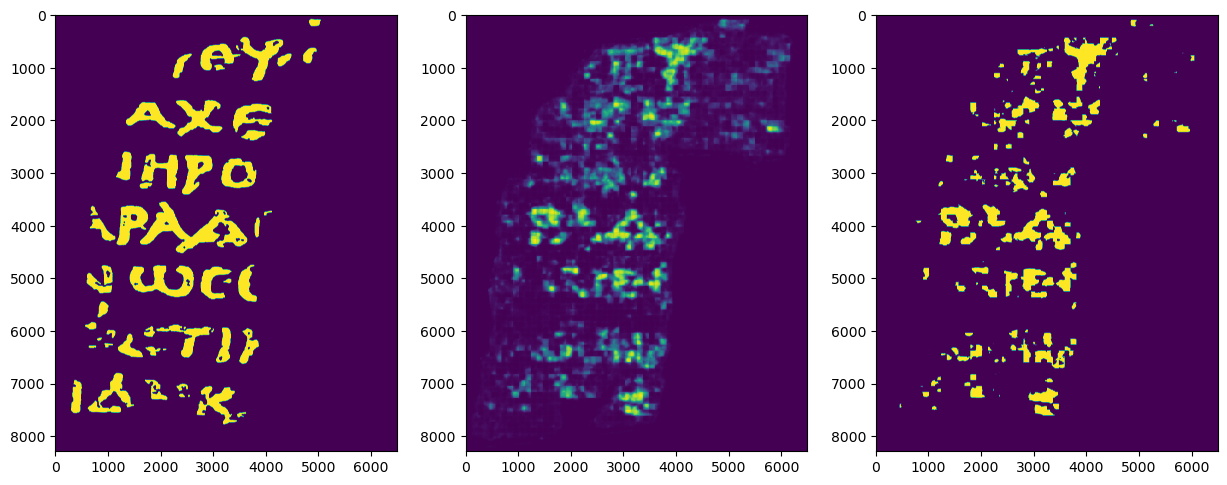

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([4.3527575e+07, 2.3688460e+06, 1.5098730e+06, 1.0224110e+06,
        8.6421000e+05, 6.8185400e+05, 5.9463000e+05, 4.8428100e+05,
        3.9918400e+05, 3.3732600e+05, 2.8846400e+05, 2.6070900e+05,
        2.4254500e+05, 2.1438800e+05, 1.9614600e+05, 2.0231900e+05,
        2.2893800e+05, 2.3218600e+05, 1.4623500e+05, 3.6728000e+04]),
 array([2.81957064e-06, 4.79672619e-02, 9.59317043e-02, 1.43896147e-01,
        1.91860589e-01, 2.39825031e-01, 2.87789474e-01, 3.35753916e-01,
        3.83718358e-01, 4.31682801e-01, 4.79647243e-01, 5.27611686e-01,
        5.75576128e-01, 6.23540570e-01, 6.71505013e-01, 7.19469455e-01,
        7.67433897e-01, 8.15398340e-01, 8.63362782e-01, 9.11327224e-01,
        9.59291667e-01]),
 <BarContainer object of 20 artists>)

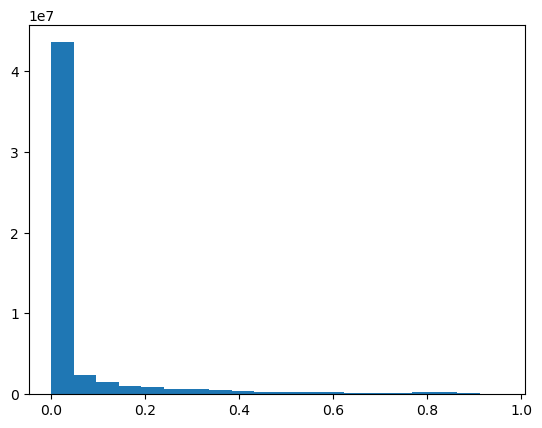

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000